## Thermal Expansion 
Calculate the thermal expansion for a Morse Pair potential using the [LAMMPS](https://www.lammps.org/) molecular dynamics
simulation code. In the following three methods to calculate the thermal expansion are introduced and compared for a 
Morse Pair Potential for Aluminium. 

As a first step the potential is defined for the [LAMMPS](https://www.lammps.org/) molecular dynamics simulation code 
by specifying the `pair_style` and `pair_coeff` commands for the [Morse Pair Potential](https://docs.lammps.org/pair_morse.html)
as well as the Aluminium bulk structure: 

In [1]:
from ase.build import bulk
import pandas

potential_dataframe = pandas.DataFrame({
    "Config": [[
        "pair_style morse/smooth/linear 9.0",
        "pair_coeff * * 0.5 1.8 2.95"
    ]],
    "Filename": [[]],
    "Model": ["Morse"],
    "Name": ["Morse"],
    "Species": [["Al"]],
})

structure = bulk("Al", a=4.05, cubic=True)

The `pandas.DataFrame` based format to specify interatomic potentials is the same `pylammpsmpi` uses to interface with 
the [NIST database for interatomic potentials](https://www.ctcms.nist.gov/potentials). In comparison to just providing
the `pair_style` and `pair_coeff` commands, this extended format enables referencing specific files for the interatomic
potentials `"Filename": [[]],` as well as the atomic species `"Species": [["Al"]],` to enable consistency checks if the 
interatomic potential implements all the interactions to simulate a given atomic structure. 

Finally, the last step of the preparation before starting the actual calculation is optimizing the interatomic structure. 
While for the Morse potential used in this example this is not necessary, it is essential for extending this example to
other interactomic potentials. For the structure optimization the `optimize_positions_and_volume()` function is imported
and applied on the `ase.atoms.Atoms` bulk structure for Aluminium:

In [2]:
from atomistics.workflows import optimize_positions_and_volume

task_dict = optimize_positions_and_volume(structure=structure)
task_dict

{'optimize_positions_and_volume': Atoms(symbols='Al4', pbc=True, cell=[4.05, 4.05, 4.05])}

It returns a `task_dict` with a single task, the optimization of the positions and the volume of the Aluminium structure.
This task is executed with the [LAMMPS](https://www.lammps.org/) molecular dynamics simulation code using the 
`evaluate_with_lammps()` function:

In [3]:
from atomistics.calculators import evaluate_with_lammps

result_dict = evaluate_with_lammps(
    task_dict=task_dict,
    potential_dataframe=potential_dataframe,
)
structure_opt = result_dict["structure_with_optimized_positions_and_volume"]

/home/janssen/mambaforge/lib/python3.10/site-packages/pylammpsmpi/wrapper/ase.py:165: UserWarning: Warning: setting upper trangular matrix might slow down the calculation
  warnings.warn(


The `result_dict` just contains a single element, the `ase.atoms.Atoms` structure object with optimized positions and 
volume. After this step the preparation is completed and the three different approximations can be compared in the following.

### Equation of State 
The first approximation to calculate the thermal expansion is based on the Equation of State derived by [Moruzzi, V. L. et al.](https://link.aps.org/doi/10.1103/PhysRevB.37.790).
So in analogy to the previous example of calculating the elastic properties from the Equation of State, the `EnergyVolumeCurveWorkflow`
is initialized with the default parameters: 

In [4]:
from atomistics.workflows.evcurve.workflow import EnergyVolumeCurveWorkflow

workflow = EnergyVolumeCurveWorkflow(
    structure=structure_opt,
    num_points=11,
    fit_type='polynomial',
    fit_order=3,
    vol_range=0.05,
    axes=['x', 'y', 'z'],
    strains=None,
)
structure_dict = workflow.generate_structures()
structure_dict

{'calc_energy': OrderedDict([(0.95,
               Atoms(symbols='Al4', pbc=True, cell=[[3.9786988461213992, 2.43625040333692e-16, 2.43625040333692e-16], [0.0, 3.9786988461213992, 2.43625040333692e-16], [0.0, 0.0, 3.9786988461213992]])),
              (0.96,
               Atoms(symbols='Al4', pbc=True, cell=[[3.992610493736228, 2.4447688306981026e-16, 2.4447688306981026e-16], [0.0, 3.992610493736228, 2.4447688306981026e-16], [0.0, 0.0, 3.992610493736228]])),
              (0.97,
               Atoms(symbols='Al4', pbc=True, cell=[[4.00642586504517, 2.4532283058243666e-16, 2.4532283058243666e-16], [0.0, 4.00642586504517, 2.4532283058243666e-16], [0.0, 0.0, 4.00642586504517]])),
              (0.98,
               Atoms(symbols='Al4', pbc=True, cell=[[4.020146608667117, 2.461629838203636e-16, 2.461629838203636e-16], [0.0, 4.020146608667117, 2.461629838203636e-16], [0.0, 0.0, 4.020146608667117]])),
              (0.99,
               Atoms(symbols='Al4', pbc=True, cell=[[4.03377432851074

After the initialization the `generate_structures()` function is called to generate the atomistic structures which are
then in the second step evaluated with the [LAMMPS](https://www.lammps.org/) molecular dynamics simulation code to derive
the equilibrium properties:

In [5]:
result_dict = evaluate_with_lammps(
    task_dict=structure_dict, 
    potential_dataframe=potential_dataframe
)
result_dict

{'energy': {0.95: -14.609207927145926,
  0.96: -14.656740101454448,
  0.97: -14.692359030099395,
  0.98: -14.716883724875528,
  0.99: -14.731079276327009,
  1.0: -14.735659820057942,
  1.01: -14.731295089579728,
  1.02: -14.718611862249286,
  1.03: -14.698196715842329,
  1.04: -14.670598736769112,
  1.05: -14.636332030744796}}

While in the previous example the fit of the energy volume curve was used directly, there the output of the fit, in
particular the derived equilibrium properties are the input for the Debye model as defined by [Moruzzi, V. L. et al.](https://link.aps.org/doi/10.1103/PhysRevB.37.790):

In [6]:
from atomistics.shared.thermo.debye import get_debye_model
from atomistics.shared.thermo.thermo import get_thermo_bulk_model
import numpy as np

debye_model = get_debye_model(
    fit_dict=workflow.analyse_structures(output_dict=result_dict), 
    masses=structure.get_masses(), 
    num_steps=50
)
T_debye_low, T_debye_high = debye_model.debye_temperature
pes = get_thermo_bulk_model(
    temperatures=np.linspace(1, 1500, 200),
    debye_model=debye_model,
)

/home/janssen/mambaforge/lib/python3.10/site-packages/atomistics/shared/thermo/debye.py:9: RuntimeWarning: overflow encountered in exp
  return xi**3 / (np.exp(xi) - 1)


The output of the Debye model provides the change of the temperature specific optimal volume `pes.get_minimum_energy_path()`
which can be plotted over the temperature `pes.temperatures` to determine the thermal expansion. 

### Quasi-Harmonic Approximation 
While the [Moruzzi, V. L. et al.](https://link.aps.org/doi/10.1103/PhysRevB.37.790) approach based on the Einstein crystal
is limited to a single frequency, the quasi-harmonic model includes the volume dependent free energy. Inside the 
`atomistics` package the harmonic and quasi-harmonic model are implemented based on an interface to the [Phonopy](https://phonopy.github.io/phonopy/)
framework. Still the user interface is still structured in the same three steps of (1) generating structures, (2) evaluating 
these structures and (3) fitting the corresponding model. Starting with the initialization of the `QuasiHarmonicWorkflow`
which combines the `PhonopyWorkflow` with the `EnergyVolumeCurveWorkflow`:

In [7]:
from atomistics.workflows.quasiharmonic.workflow import QuasiHarmonicWorkflow
from phonopy.units import VaspToTHz

calculator = QuasiHarmonicWorkflow(
    structure=structure_opt,
    num_points=11,
    vol_range=0.05,
    interaction_range=10,
    factor=VaspToTHz,
    displacement=0.01,
    dos_mesh=20,
    primitive_matrix=None,
    number_of_snapshots=None,
)
structure_dict = calculator.generate_structures()
structure_dict

{'calc_energy': OrderedDict([(0.95,
               Atoms(symbols='Al4', pbc=True, cell=[[3.9786988461213992, 2.43625040333692e-16, 2.43625040333692e-16], [0.0, 3.9786988461213992, 2.43625040333692e-16], [0.0, 0.0, 3.9786988461213992]])),
              (0.96,
               Atoms(symbols='Al4', pbc=True, cell=[[3.992610493736228, 2.4447688306981026e-16, 2.4447688306981026e-16], [0.0, 3.992610493736228, 2.4447688306981026e-16], [0.0, 0.0, 3.992610493736228]])),
              (0.97,
               Atoms(symbols='Al4', pbc=True, cell=[[4.00642586504517, 2.4532283058243666e-16, 2.4532283058243666e-16], [0.0, 4.00642586504517, 2.4532283058243666e-16], [0.0, 0.0, 4.00642586504517]])),
              (0.98,
               Atoms(symbols='Al4', pbc=True, cell=[[4.020146608667117, 2.461629838203636e-16, 2.461629838203636e-16], [0.0, 4.020146608667117, 2.461629838203636e-16], [0.0, 0.0, 4.020146608667117]])),
              (0.99,
               Atoms(symbols='Al4', pbc=True, cell=[[4.03377432851074

In contrast to the previous workflows which only used the `calc_energy` function of the simulation codes the `PhonopyWorkflow`
and correspondingly also the `QuasiHarmonicWorkflow` require the calculation of the forces `calc_forces` in addition to
the calculation of the energy. Still the general steps of the workflow remain the same: 

In [8]:
result_dict = evaluate_with_lammps(
    task_dict=structure_dict,
    potential_dataframe=potential_dataframe,
)

The `structure_dict` is evaluated with the [LAMMPS](https://www.lammps.org/) molecular dynamics simulation code to 
calculate the corresponding energies and forces. The output is not plotted here as the forces for the 108 atom cells 
result in 3x108 outputs per cell. Still the structure of the `result_dict` again follows the labels of the `structure_dict`
as explained before. Finally, in the third step the individual free energy curves at the different temperatures are 
fitted to determine the equilibrium volume at the given temperature. 

In [9]:
eng_internal_dict, mesh_collect_dict, dos_collect_dict = calculator.analyse_structures(output_dict=result_dict)
tp_collect_dict = calculator.get_thermal_properties(t_min=1, t_max=1500, t_step=50, temperatures=None)  

temperatures = tp_collect_dict[1.0]['temperatures']
temperature_max = max(temperatures)
strain_lst = eng_internal_dict.keys()
volume_lst = calculator.get_volume_lst()
eng_int_lst = np.array(list(eng_internal_dict.values()))

fit_deg = 4
vol_best = volume_lst[int(len(volume_lst)/2)]
vol_lst, eng_lst = [], []
for i, temp in enumerate(temperatures):
    free_eng_lst = np.array([tp_collect_dict[s]['free_energy'][i] for s in strain_lst]) + eng_int_lst
    p = np.polyfit(volume_lst, free_eng_lst, deg=fit_deg)
    extrema = np.roots(np.polyder(p, m=1)).real
    vol_select = extrema[np.argmin(np.abs(extrema - vol_best))]
    eng_lst.append(np.poly1d(p)(vol_select))
    vol_lst.append(vol_select)

The optimal volume at the different `temperatures` is stored in the `vol_lst` in analogy to the previous section. 

### Molecular Dynamics
Finally, the third and most commonly used method to determine the volume expansion is using a molecular dynamics 
calculation. While the `atomistics` package already includes a `LangevinWorkflow` at this point we use the [Nose-Hoover
thermostat implemented in LAMMPS](https://docs.lammps.org/fix_nh.html) directly via the [pylammpsmpi](https://github.com/pyiron/pylammpsmpi)
interface. 

In [10]:
from jinja2 import Template
from pylammpsmpi import LammpsASELibrary
from tqdm import tqdm

def calc_thermal_expansion_md(structure, potential_dataframe, temperature_lst):
    init_str = """\
thermo_style custom step temp pe etotal pxx pxy pxz pyy pyz pzz vol
thermo_modify format float %20.15g
timestep 0.001
thermo {{ thermotime }}
velocity all create $(2 * {{ lowtemp }}) 4928459 dist gaussian
"""

    run_str = """\
fix ensemble all npt temp {{ lowtemp }} {{ hightemp }} 0.1 iso 0.0 0.0 1.0
run {{ steps }}
"""

    lmp = LammpsASELibrary()
    potential_series = potential_dataframe.iloc[0]
    lmp.interactive_structure_setter(
        structure=structure,
        units="metal",
        dimension=3,
        boundary=" ".join(["p" if coord else "f" for coord in structure.pbc]),
        atom_style="atomic",
        el_eam_lst=potential_series.Species,
        calc_md=False,
    )
    for c in potential_series.Config:
        lmp.interactive_lib_command(c)
    init_str_rendered = Template(init_str).render(
        thermotime=100,
        lowtemp=10
    )
    for l in init_str_rendered.split("\n"):
        lmp.interactive_lib_command(l)
    
    volume_md_lst = []
    for temp in tqdm(temperature_lst):
        run_str_rendered = Template(run_str).render(
            steps=100,
            lowtemp=temp-5,
            hightemp=temp,
        )
        for l in run_str_rendered.split("\n"):
            lmp.interactive_lib_command(l)
        volume_md_lst.append(lmp.interactive_volume_getter())
    lmp.close()
    return volume_md_lst

The `calc_thermal_expansion_md()` function defines a loop over a vector of temperatures in 5K steps. For each step 100
molecular dynamics steps are executed before the temperature is again increased by 5K. For ~280 steps with the Morse 
Pair Potential this takes approximately 5 minutes on a single core. These simulations can be further accelerated by 
adding the `cores` parameter during the initialization of the `LammpsASELibrary()`. The increase in computational cost
is on the one hand related to the large number of force and energy calls and on the other hand to the size of the atomistic
structure, as these simulations are typically executed with >5000 atoms rather than the 4 or 108 atoms in the other 
approximations. 

In [11]:
structure_md = structure_opt.repeat(11)
temperature_md_lst = np.linspace(15, 1400, 278)
volume_md_lst = calc_thermal_expansion_md(
    structure=structure_md, 
    potential_dataframe=potential_dataframe, 
    temperature_lst=temperature_md_lst, 
)

100%|█████████████████████████████████████████| 278/278 [04:37<00:00,  1.00it/s]


The volume for the individual temperatures is stored in the `volume_md_lst` list. 

### Summary
To visually compare the thermal expansion predicted by the three different approximations, the [matplotlib](https://matplotlib.org)
is used to plot the temperature over the volume:

Text(0, 0.5, 'Temperature')

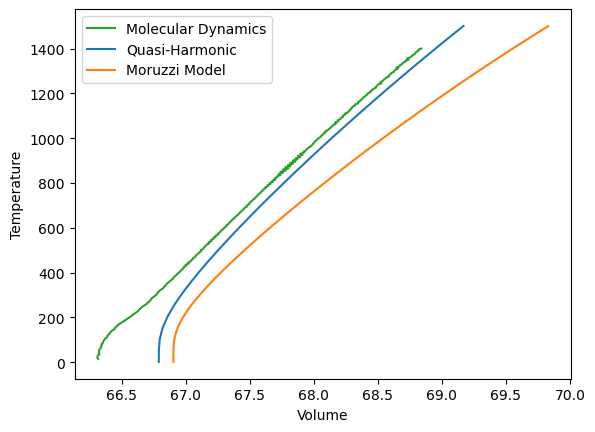

In [12]:
import matplotlib.pyplot as plt
plt.plot(np.array(volume_md_lst)/len(structure_md) * len(structure_opt), temperature_md_lst, label="Molecular Dynamics", color="C2")
plt.plot(vol_lst, temperatures, label="Quasi-Harmonic", color="C0")
plt.plot(pes.get_minimum_energy_path(), pes.temperatures, label="Moruzzi Model", color="C1")
plt.legend()
plt.xlabel("Volume")
plt.ylabel("Temperature")

While the both the [Moruzzi, V. L. et al.](https://link.aps.org/doi/10.1103/PhysRevB.37.790) and the quasi-harmonic 
approach over-predict the volume expansion with increasing temperature the overall result is in reasonable agreement for
the Morse Pair Potential. 